<h1>Applied Machine Learning Assignment 2 Question 2</h1>

This assignment involves giving a practical programming experience with dimensionality reduction, unsupervised learning, and neural networks by working with a dataset of flower images, specifically tulips and sunflowers, to build and optimize a model that can effectively classify these images. Through this task, you will explore techniques such as PCA (Principal Component Analysis) for dimensionality reduction, use unsupervised learning for feature extraction, and apply neural network architectures to improve classification accuracy.

<h3>About Dataset</h3>

Context<br>
This dataset contains 1717 images of flowers.
The data collection is based on the data flicr, google images, yandex images.

Content<br>
The pictures are divided into two classes: tulip, sunflower
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels.

In [33]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.stats import mode
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

<h3>Q1)
Apply PCA to the images from folder. How many components do you need to preserve 90% of the variance?
</h3>

In [35]:
dataset_path = "flowers"
categories = os.listdir(dataset_path)

dataset_info = {}

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        dataset_info[category] = [os.path.join(category_path, img) for img in images]
        
for category, images in dataset_info.items():
    print(f"Category: {category}, Number of Images: {len(images)}")


Category: sunflower, Number of Images: 733
Category: tulip, Number of Images: 984


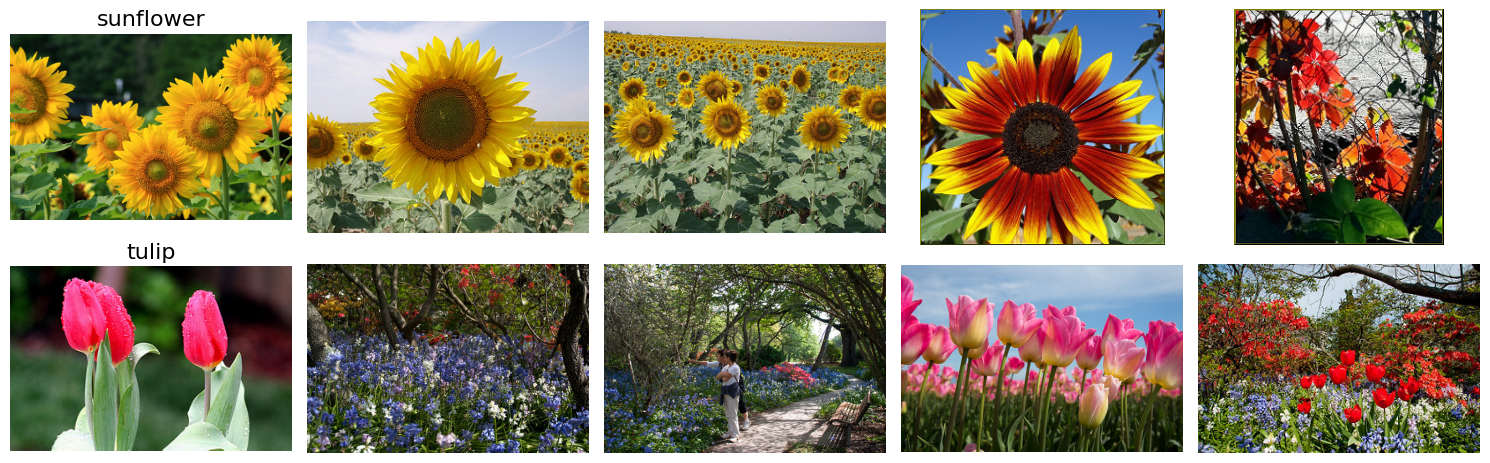

In [36]:
num_samples=5
fig, axes = plt.subplots(len(dataset_info), num_samples, figsize=(15, 5))
for idx, (category, image_paths) in enumerate(dataset_info.items()):
    for j in range(num_samples):
        if j < len(image_paths):
            img = Image.open(image_paths[j])
            axes[idx, j].imshow(img)
            axes[idx, j].axis('off')
            if j == 0:
                axes[idx, j].set_title(category, fontsize=16)
        else:
            axes[idx, j].axis('off')
plt.tight_layout()
plt.show()

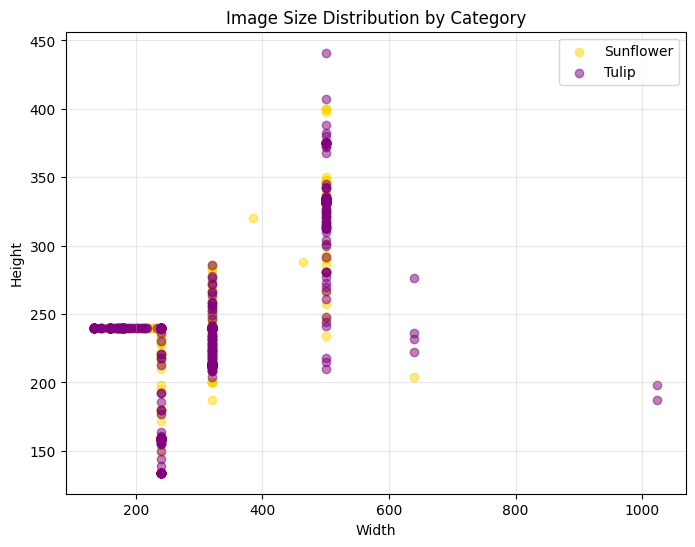

In [37]:
category_colors = {
    "sunflower": "gold",
    "tulip": "purple"
}

plt.figure(figsize=(8, 6))

for category, image_paths in dataset_info.items():
    sizes = [Image.open(img).size for img in image_paths]
    widths, heights = zip(*sizes)
    plt.scatter(widths, heights, alpha=0.5, label=category.capitalize(), color=category_colors.get(category, "gray"))

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution by Category')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [38]:

input_dir = "flowers"
output_dir = "processed_flowers"

os.makedirs(output_dir, exist_ok=True)

target_size = (64, 64)

def process_images(input_dir, output_dir, target_size):
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)
        
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                input_image_path = os.path.join(category_path, image_name)
                output_image_path = os.path.join(output_category_path, image_name)
                
                try:
                    with Image.open(input_image_path) as img:
                        img_gray = img.convert('L')
                        img_resized = img_gray.resize(target_size)
                        img_resized.save(output_image_path)
                except Exception as e:
                    print(f"Error processing {input_image_path}: {e}")

process_images(input_dir, output_dir, target_size)

print(f"Images processed and saved to '{output_dir}'.")


Images processed and saved to 'processed_flowers'.


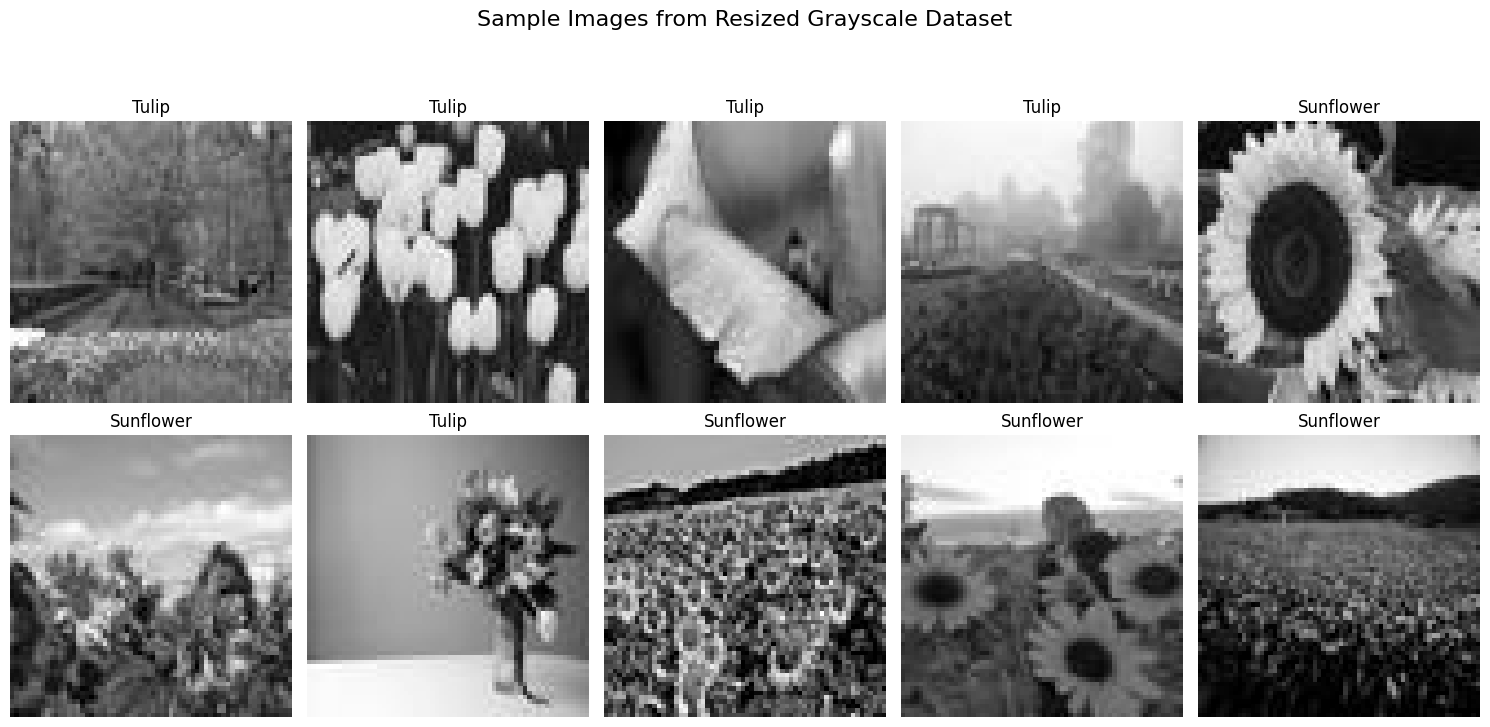

In [39]:
def display_sample_images(input_dir, num_samples=10):
    rows = 2 
    cols = num_samples // rows + (num_samples % rows > 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    fig.suptitle("Sample Images from Resized Grayscale Dataset", fontsize=16)
    
    categories = os.listdir(input_dir)
    axes = axes.flatten() 
    
    for i, ax in enumerate(axes):
        if i < num_samples:
            category = random.choice(categories)
            category_path = os.path.join(input_dir, category)
            image_name = random.choice(os.listdir(category_path))
            image_path = os.path.join(category_path, image_name)
            
            with Image.open(image_path) as img:
                ax.imshow(img, cmap='gray')
                ax.set_title(category.capitalize())
                ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_sample_images(output_dir)


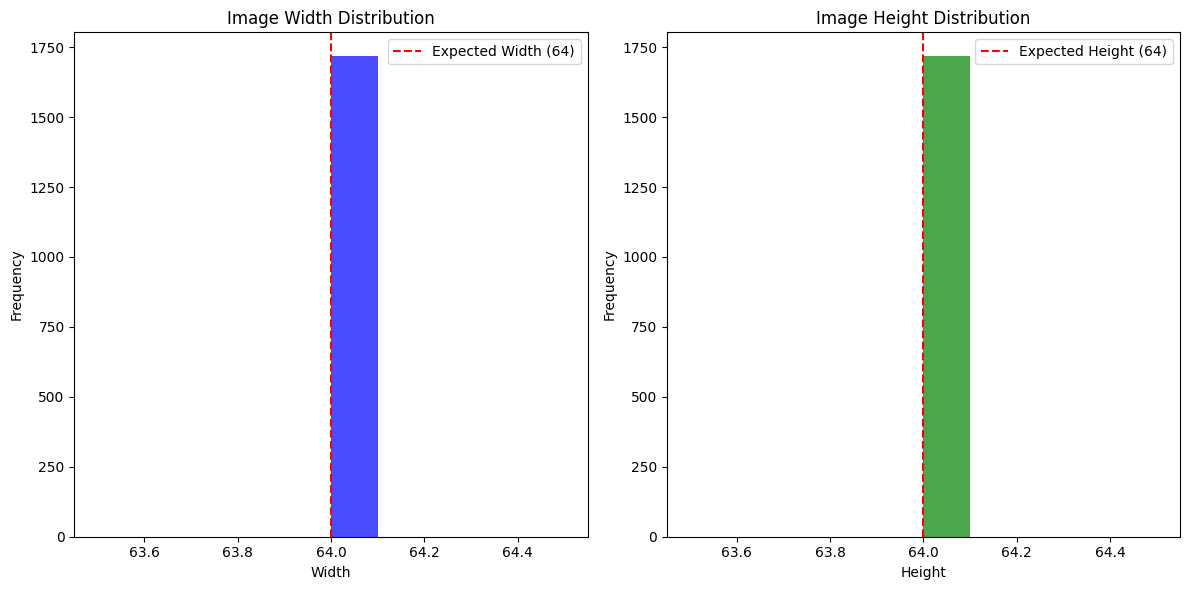

In [40]:
def plot_resized_image_sizes(output_dir):
    widths = []
    heights = []
    categories = os.listdir(output_dir)

    for category in categories:
        category_path = os.path.join(output_dir, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            with Image.open(image_path) as img:
                widths.append(img.width)
                heights.append(img.height)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=10, color='blue', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.axvline(x=64, color='red', linestyle='--', label='Expected Width (64)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=10, color='green', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.axvline(x=64, color='red', linestyle='--', label='Expected Height (64)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_resized_image_sizes(output_dir)


In [41]:
def split_and_combine_dataset(input_dir, output_train_dir, output_val_dir, test_size=0.3):
    os.makedirs(output_train_dir, exist_ok=True)
    os.makedirs(output_val_dir, exist_ok=True)
    
    categories = os.listdir(input_dir)
    
    image_paths = []
    
    for category in categories:
        category_path = os.path.join(input_dir, category)
        
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image_paths.append(image_path)
    
    train_paths, val_paths = train_test_split(image_paths, test_size=test_size, random_state=42)
    
    def move_images(image_paths, target_dir):
        for img_path in image_paths:
            shutil.copy(img_path, target_dir)
    
    move_images(train_paths, output_train_dir)
    move_images(val_paths, output_val_dir)

    print(f"Training and validation datasets have been successfully created.\n"
          f"Training images: {len(train_paths)}\n"
          f"Validation images: {len(val_paths)}")


output_train_dir = 'train_data'
output_val_dir = 'val_data'

split_and_combine_dataset(output_dir, output_train_dir, output_val_dir, test_size=0.3)


Training and validation datasets have been successfully created.
Training images: 1201
Validation images: 516


Number of components needed to preserve 90% of the variance: 228


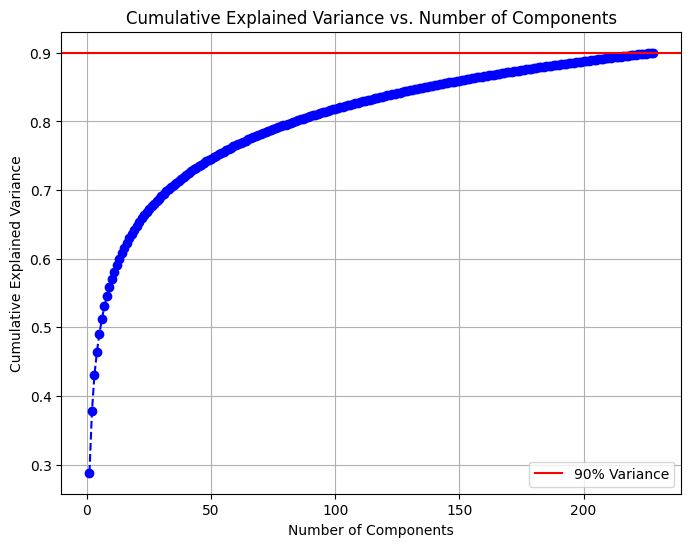

In [42]:
def load_images_from_folder(folder, image_size=(64, 64)):
    image_data = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        
        label = image_name.split()[0]
        labels.append(label)
        
        with Image.open(image_path) as img:
            img = img.convert('L')
            img_resized = img.resize(image_size)
            img_array = np.array(img_resized).flatten()
            image_data.append(img_array)
        
        image_paths.append(image_path)
    
    return np.array(image_data), np.array(labels), np.array(image_paths)

train_folder = 'train_data'

image_data, labels, image_paths = load_images_from_folder(train_folder)

pca = PCA(n_components=0.90)
pca.fit(image_data)

num_components = pca.n_components_
print(f"Number of components needed to preserve 90% of the variance: {num_components}")

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.axhline(y=0.90, color='r', linestyle='-', label="90% Variance")
plt.title("Cumulative Explained Variance vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


<h5>Number of components needed to preserve 90% of the variance is 228</h5>

Graph:<br>
This graph shows the **cumulative explained variance** vs. the number of PCA components. The red line marks the 90% variance threshold. It helps identify the minimum number of components needed to retain 90% of the data's information, balancing dimensionality reduction and variance preservation.

<h2>Q2)
Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.
</h2>

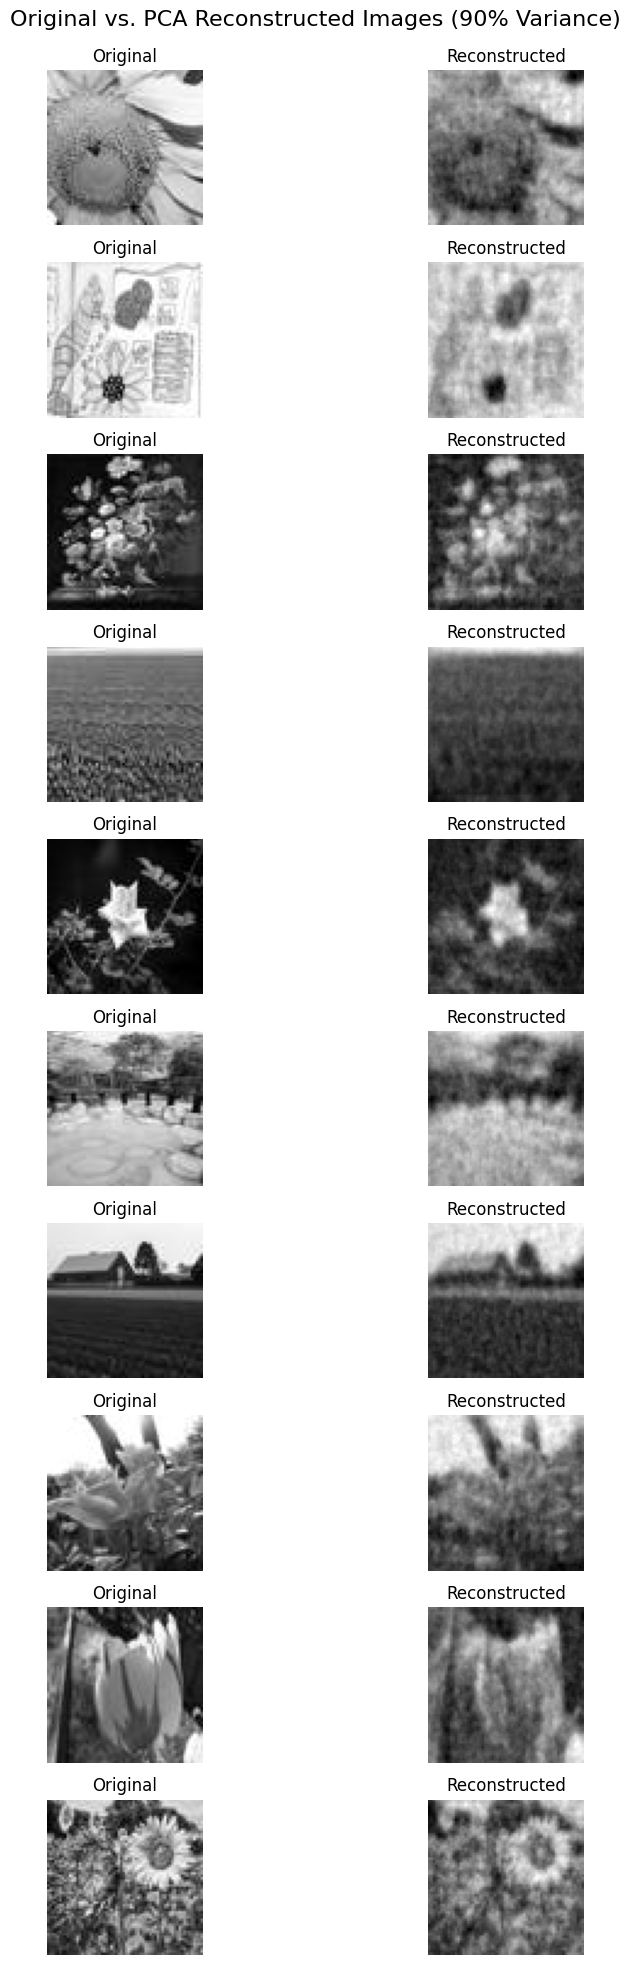

In [43]:

image_data_pca = pca.transform(image_data)
reconstructed_data = pca.inverse_transform(image_data_pca)

num_images = 10
indices = np.random.choice(image_data.shape[0], num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
fig.suptitle("Original vs. PCA Reconstructed Images (90% Variance)", fontsize=16)

for i, idx in enumerate(indices):
    original_image = image_data[idx].reshape(64, 64)
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Original")

    reconstructed_image = reconstructed_data[idx].reshape(64, 64)
    axes[i, 1].imshow(reconstructed_image, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Reconstructed")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [44]:
labels

array(['sunflower_001.jpg', 'sunflower_002.jpg', 'sunflower_003.jpg', ...,
       'tulip_982.jpg', 'tulip_983.jpg', 'tulip_984.jpg'], dtype='<U17')

<h2>Q3)
Each of the images belongs to one of two flower categories. We will now try to see if the visualization can help us identify different clusters.
</h2>

<h3>A)
Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components? 
</h3>

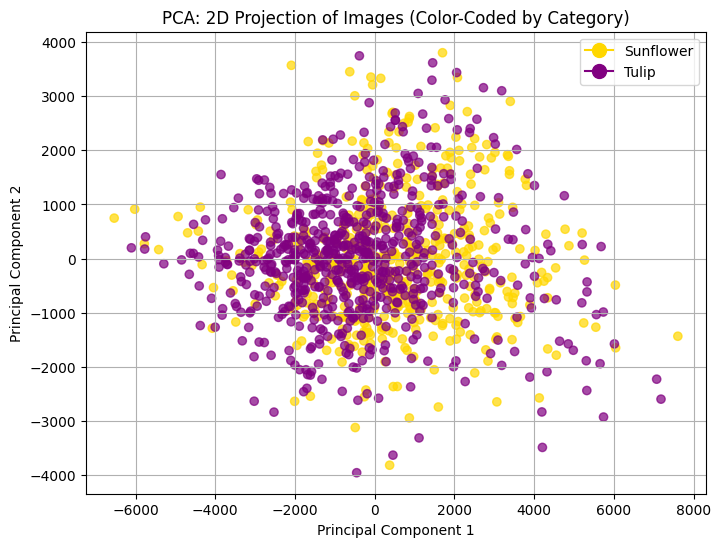

In [45]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_data)

plt.figure(figsize=(8, 6))

img_color = [image_name.split('_')[0] for image_name in labels]

colors = ['gold' if category == 'sunflower' else 'purple' for category in img_color]

scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.7)

import matplotlib.lines as mlines
sunflower_legend = mlines.Line2D([], [], marker='o', color='gold', label='Sunflower', markersize=10)
tulip_legend = mlines.Line2D([], [], marker='o', color='purple', label='Tulip', markersize=10)

plt.legend(handles=[sunflower_legend, tulip_legend])

plt.title("PCA: 2D Projection of Images (Color-Coded by Category)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()



In [46]:
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

print('The Explained variance for first 2 principal components are', 
      '\nFirst Component - ', explained_variance[0]*100, 
      '\nSecond Component - ', explained_variance[1]*100,
      '\nTotal Component - ', total_explained_variance*100
      )


The Explained variance for first 2 principal components are 
First Component -  28.816008065504917 
Second Component -  8.938654237990274 
Total Component -  37.75466230349519


<h4>2D PCA Projection Graph</h4>

This graph represents a **2D PCA projection** of images categorized as **Sunflower (yellow)** and **Tulip (purple)**. The two principal components (x and y axes) capture the most variance in the dataset, allowing visualization of how the categories overlap or separate in reduced dimensions. The overlap suggests some difficulty in distinguishing the categories based solely on these components.

<h3>B)
Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category. Then add some images to the visualization to better understand what features in the images are accounting for the majority of variance in the data. Repeat the process and create the same type of plots for t-SNE, LLE and MDS.  

C)
Discuss the findings.
</h3>

In [47]:
def plot_dimensionality_reduction(method='pca', X=pca_result, y=img_color, images=image_data, min_distance=0.04, figsize=(16, 8)):
    
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'lle':
        reducer = LocallyLinearEmbedding(n_components=2, random_state=42)
    elif method == 'mds':
        reducer = MDS(n_components=2, random_state=42)

    X_normalized = MinMaxScaler().fit_transform(X)
    reduced_data = reducer.fit_transform(X_normalized)

    label_map = {'sunflower': 0, 'tulip': 1}
    numeric_labels = np.array([label_map[label] for label in y])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    cmap = plt.cm.viridis
    scatter = axes[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, alpha=0.6, cmap=cmap)
    axes[0].set_title(f"{method.upper()}: 2D Scatter Plot")
    axes[0].set_xlabel("Dimension 1")
    axes[0].set_ylabel("Dimension 2")
    axes[0].grid(True)
    plt.colorbar(scatter, ax=axes[0], label="Flower Type")

    axes[1].scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0)
    axes[1].set_title(f"{method.upper()}: 2D Projection with Flower Images")
    axes[1].axis("off")

    ax = axes[1]
    neighbors = np.array([[10., 10.]])
    for index, image_coord in enumerate(reduced_data):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]

            if images is not None:
                image = images[index].reshape(64, 64)
                imagebox = AnnotationBbox(OffsetImage(image, zoom=0.2, cmap="gray"), image_coord, frameon=False)
                ax.add_artist(imagebox)

    plt.tight_layout()
    plt.show()


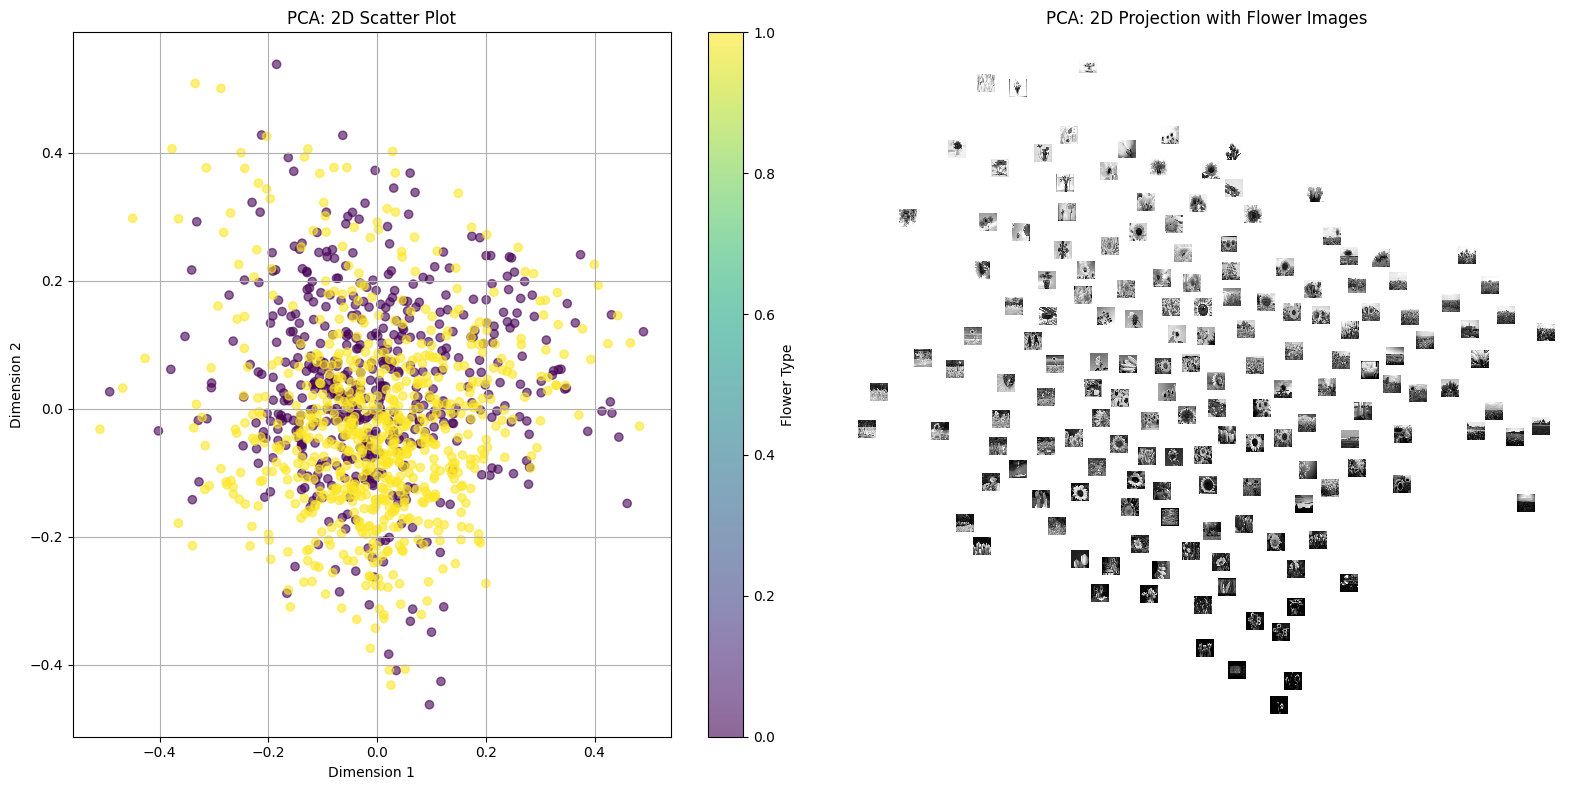

In [48]:
plot_dimensionality_reduction()

<h2>PCA visualization shows that:</h2>
<h4>

1. The dense central cluster with mixed yellow and purple dots shows significant overlap between flower types.
2. The gradual spread from center to edges suggests continuous variation in flower characteristics rather than distinct groups.
3. While there is some separation between the yellow and purple classes in certain areas, the substantial mixing indicates shared features between flower types.
4. The pattern suggests that distinguishing between flower types may be challenging since their visual characteristics gradually blend into each other rather than showing clear boundaries.</h4>

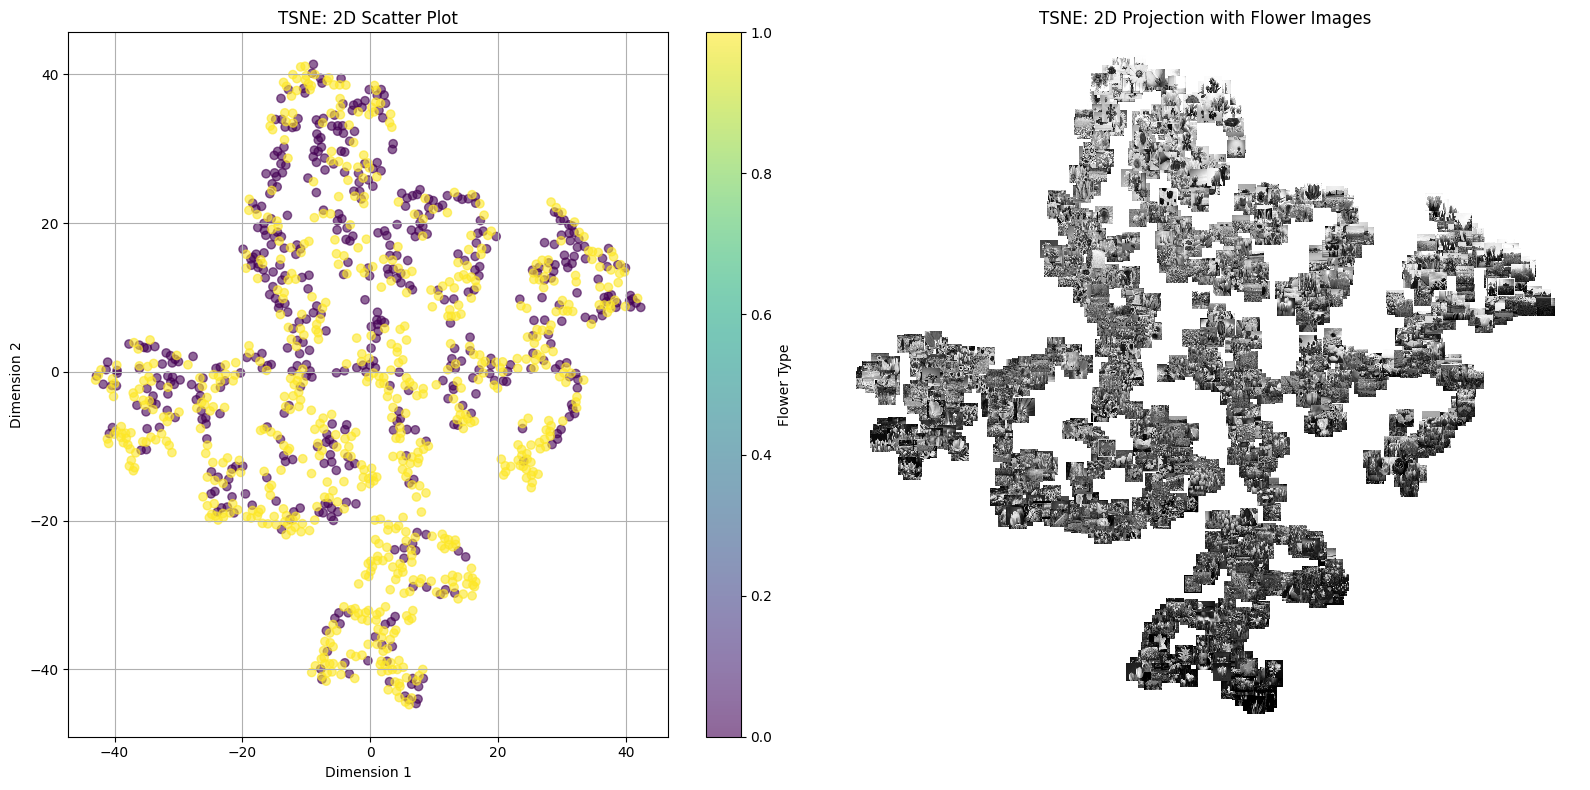

In [25]:
plot_dimensionality_reduction(method='tsne')

<h2>
This TSNE (t-Distributed Stochastic Neighbor Embedding) visualization shows a different pattern from the PCA plot:
</h2>
<h4>

1. The flower images are arranged in more distinct, separated clusters, suggesting TSNE was better at identifying natural groupings in the flower data.

2. Unlike the PCA plot's central concentration, this visualization shows multiple distinct "islands" or clusters, indicating clearer separation between different flower types.

3. Similar flower images appear to be grouped together in their own regions, suggesting TSNE successfully captured local similarities between flower characteristics.

4. The branching, non-linear structure suggests complex relationships between flower types that weren't visible in the more linear PCA projection.

This suggests TSNE may be more effective at revealing the natural groupings in this flower dataset compared to PCA's more overlapped representation.</h4>

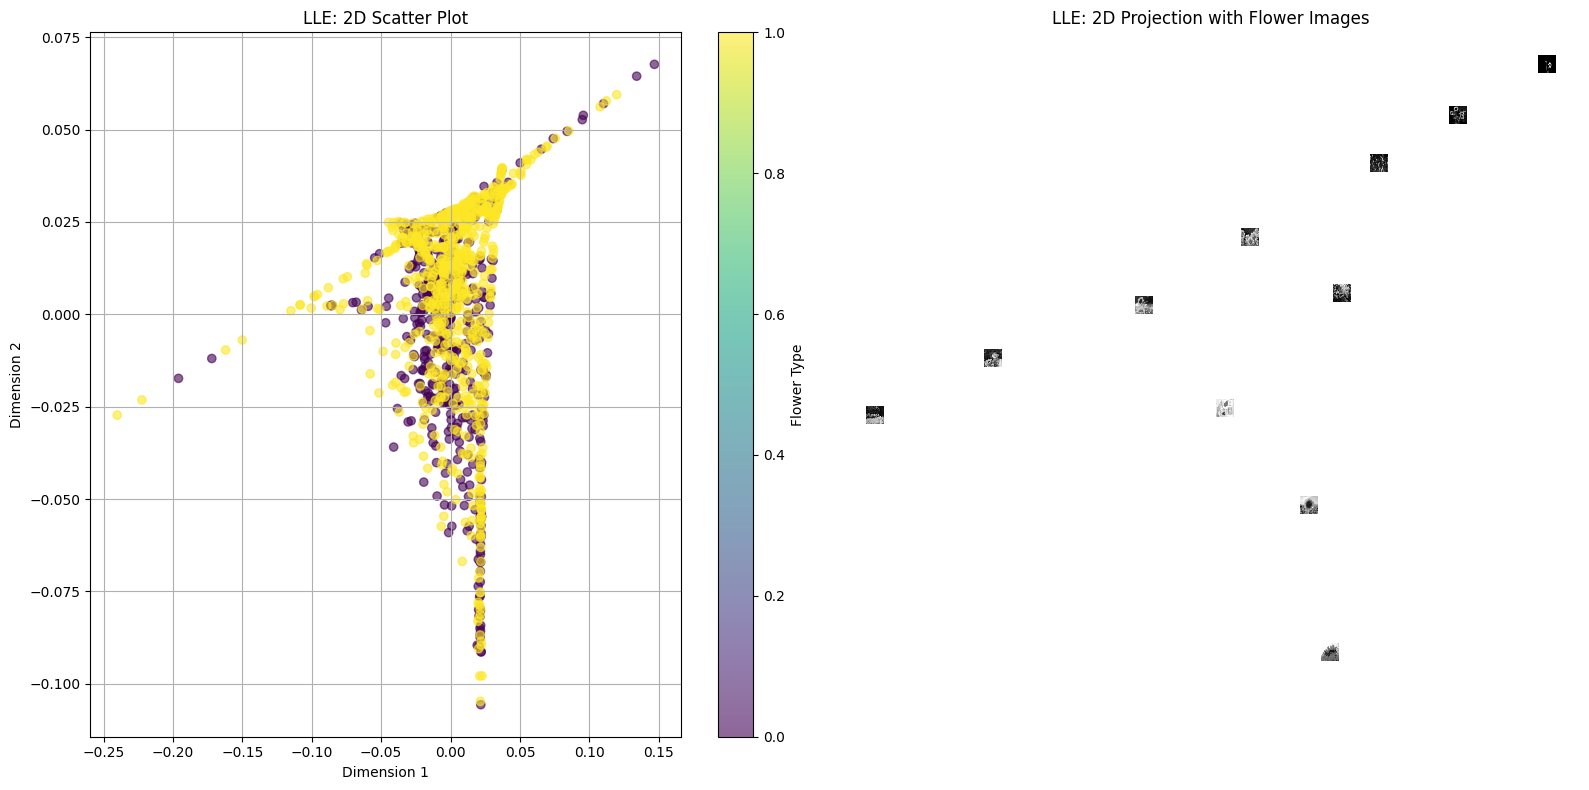

In [26]:
plot_dimensionality_reduction(method='lle')

<h2>
The LLE (Locally Linear Embedding) 2D projection shows a distinctive pattern:
</h2>
<h4>

1. Points form a distinctive "V" or bird-like shape, with a clear linear progression at the bottom that splits into two branches.

2. The yellow and purple dots show some clear separation patterns:
   - Yellow dots dominate the lower region
   - More mixing of yellow and purple dots occurs in the branching sections
   - Some distinct clusters appear at the edges

3. The structure suggests that flower characteristics evolve gradually along a main path before diverging into two distinct groups.

4. Unlike PCA's scattered pattern or TSNE's isolated clusters, LLE reveals a more continuous, structured relationship between flower types while still showing clear separations.

This visualization suggests LLE has captured both local and global relationships in the flower dataset, showing how different flower types might be evolutionarily or morphologically related.
</h4>

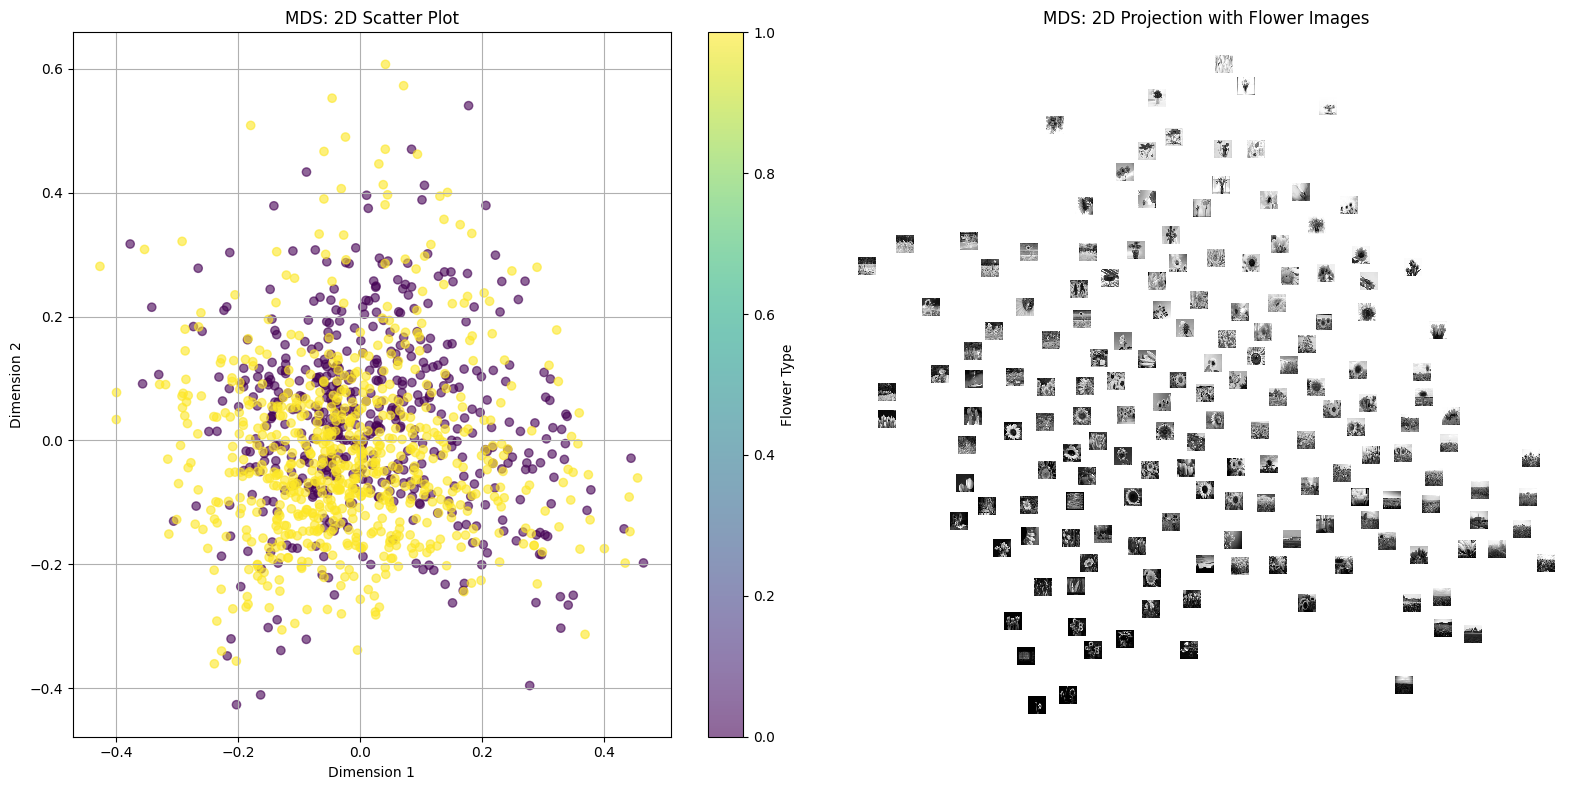

In [27]:
plot_dimensionality_reduction(method='mds')

<h2>
The MDS 2D projection with flower images shows that:
</h2>
<h5>

1. A dense central cluster with points spreading outward
2. Small flower images with yellow and purple dots scattered throughout
3. Points that are closer together represent similar flower images, while those far apart are more different
4. The spread suggests both common patterns (clustered center) and unique examples (outer edges)

This visualization effectively shows how similar or different the flower images are from each other in a simplified 2D space.
The spread of the data suggests there's both commonality and diversity in the flower image dataset, with some clear groupings as well as unique examples that don't fit neatly into the main clusters.
</h5>

<h2>5) Cluster the images using K-Means.</h2>

<h4>
A) You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.

B) Set the number of clusters and report clustering accuracy.
</h4>

In [49]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(image_data)


pca = PCA(n_components=0.90)
X_reduced = pca.fit_transform(X_normalized)


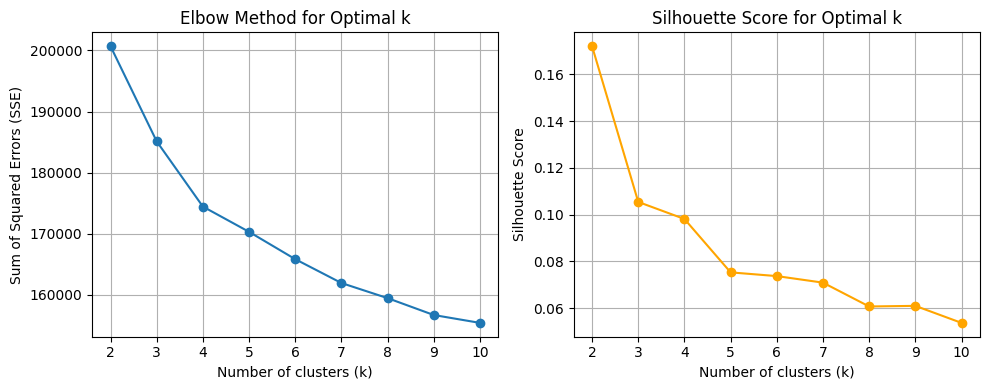

In [50]:
max_k=10
sse = []
silhouette_scores = []
k_range = range(2, max_k + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    
    sse.append(kmeans.inertia_)        
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axes[0].plot(k_range, sse, marker='o')
axes[0].set_title("Elbow Method for Optimal k")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Sum of Squared Errors (SSE)")
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
axes[1].set_title("Silhouette Score for Optimal k")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [51]:
def evaluate_clustering(X, y, n_clusters=2, algorithm="kmeans"):

    label_map = {'sunflower': 0, 'tulip': 1}
    numeric_labels = np.array([label_map[label] for label in y])

    if algorithm == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=42)
        predicted_labels = model.fit_predict(X)
    elif algorithm == "gmm":
        model = GaussianMixture(n_components=n_clusters, random_state=42)
        predicted_labels = model.fit_predict(X)
    else:
        raise ValueError("Invalid algorithm. Choose 'kmeans' or 'gmm'.")

    label_mapping = {}
    for cluster in range(n_clusters):
        mask = (predicted_labels == cluster)
        cluster_labels = numeric_labels[mask]

        if len(cluster_labels) > 0:
            mode_result = mode(cluster_labels)
            label_mapping[cluster] = mode_result.mode
        else:
            label_mapping[cluster] = -1
    

    mapped_predictions = np.array([label_mapping[cluster] for cluster in predicted_labels])

    accuracy = accuracy_score(numeric_labels, mapped_predictions)
    return accuracy


In [52]:
kmeans_accuracy = evaluate_clustering(X_reduced, img_color, n_clusters=2, algorithm="kmeans")
print(f"KMeans Clustering Accuracy: {kmeans_accuracy * 100:.2f}%")

KMeans Clustering Accuracy: 61.53%


<h3>Based on the Silhouette Score plot, the optimal value for k (number of clusters) appears to be 2.</h3>

A higher Silhouette Score indicates better-defined clusters.
The plot shows a peak at k=2, indicating that this is the point where the clusters are most distinct and well-separated.
As the number of clusters increases beyond 2, the Silhouette Score generally decreases, suggesting that the clusters become less distinct and less well-defined.
Therefore, choosing k=2 would likely result in the best clustering solution for the given data.

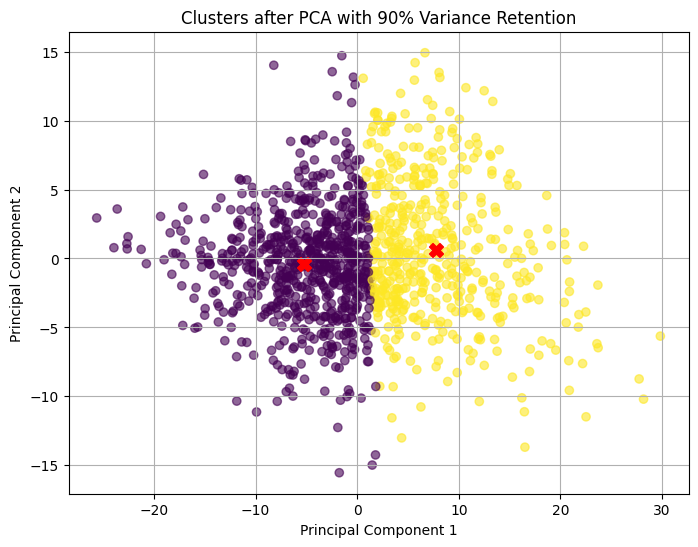

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_reduced)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='X', label='Cluster Centers')
plt.title("Clusters after PCA with 90% Variance Retention")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

<h4>Clusters after PCA</h4>

The plot shows two distinct clusters after applying PCA to reduce dimensionality. The clusters are well-separated, suggesting that the data is divided into two categories. The red crosses represent the centroids of the clusters. This visualization is used to identify outliers, understand relationships between variables, and inform further analysis.

<h2>6) 
Cluster the images using EM.
</h2>

<h4> A)
You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.
Set the number of clusters and report clustering accuracy.
Use the model to generate 20 new flowers (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method). 
</h4>

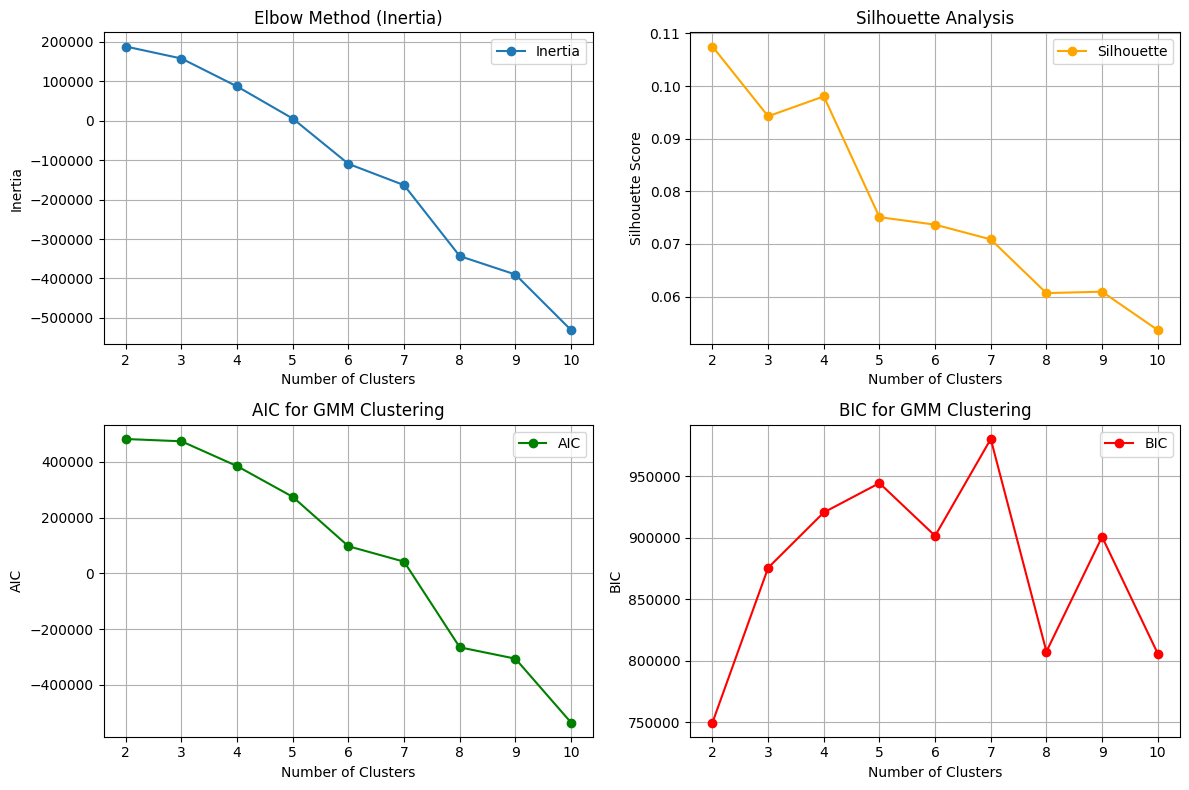

In [54]:
max_clusters=10
inertia = []
silhouette_scores = []
aic_scores = []
bic_scores = []

cluster_range = range(2, max_clusters + 1)
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_reduced)
    labels = gmm.predict(X_reduced)

    inertia.append(-gmm.score(X_reduced) * len(X_reduced))
    silhouette_scores.append(silhouette_score(X_reduced, labels))
    aic_scores.append(gmm.aic(X_reduced))
    bic_scores.append(gmm.bic(X_reduced))

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(cluster_range, inertia, marker='o', label="Inertia")
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange', label="Silhouette")
plt.title("Silhouette Analysis")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(cluster_range, aic_scores, marker='o', color='green', label="AIC")
plt.title("AIC for GMM Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("AIC")
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(cluster_range, bic_scores, marker='o', color='red', label="BIC")
plt.title("BIC for GMM Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

<h3>Based on the plots, the optimal value for k (number of clusters) appears to be 2.
</h3>

1. **Elbow Method (Inertia):**
   - Plots the within-cluster sum-of-squares (inertia) against the number of clusters.
   - The "elbow point" is the point where the curve starts to bend significantly.
   - In this case, the elbow point seems to be around **k=2**.

2. **Silhouette Analysis:**
   - Measures the similarity of data points within their own cluster compared to other clusters.
   - Higher Silhouette Scores indicate better-defined clusters.
   - The plot shows a peak around **k=2**, suggesting that this is the optimal number of clusters.

3. **AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion):**
   - These information criteria balance model fit with model complexity.
   - Lower values of AIC and BIC generally indicate better models.
   - The plots show that both AIC and BIC tend to decrease initially and then stabilize or increase slightly after **k=2**. 

**Optimal Number of Clusters:**

Based on the combined analysis of the Elbow Method, Silhouette Analysis, AIC, and BIC, **k=2** appears to be the optimal number of clusters for this dataset.


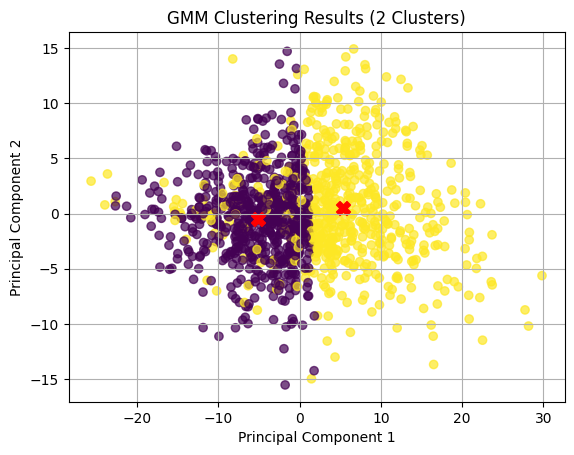

In [55]:
optimal_clusters = 2

gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(X_reduced)
gmm_labels = gmm.predict(X_reduced)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='red', marker='X', label='Cluster Centers')
plt.title(f"GMM Clustering Results ({optimal_clusters} Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

In [56]:
gmm_accuracy = evaluate_clustering(X_reduced, img_color, n_clusters=2, algorithm="gmm")
print(f"GMM Clustering Accuracy: {gmm_accuracy * 100:.2f}%")


GMM Clustering Accuracy: 59.37%


<h3>GMM Clustering Plot</h3>

The plot visualizes the results of Gaussian Mixture Model (GMM) clustering on a dataset, with the data projected onto the first two principal components. The GMM has identified two distinct clusters in the data, and the red crosses represent the mean or centroid of each cluster.

The clustering appears to be effective, with the two clusters being well-separated. This suggests that the GMM has successfully identified underlying patterns in the data.

(20, 4096)


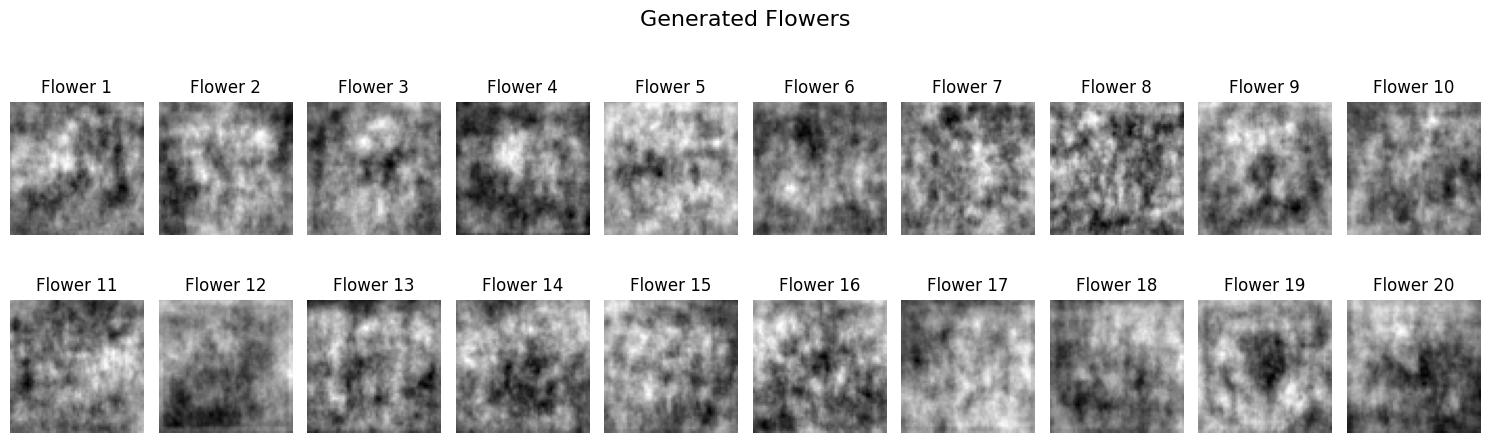

In [57]:

X_new, y_new = gmm.sample(20)
X_new_recovered = pca.inverse_transform(X_new)
print(X_new_recovered.shape)

reconstructed_new_images = X_new_recovered.reshape((20, 64, 64))

fig, axes = plt.subplots(2, 10, figsize=(15, 5))
axes = axes.flatten()

for image_index in range(20):
    ax = axes[image_index]
    ax.imshow(reconstructed_new_images[image_index], cmap='gray')
    ax.set_title(f'Flower {image_index + 1}')
    ax.axis('off')

plt.suptitle('Generated Flowers', fontsize=16)
plt.tight_layout()
plt.show()


<h3>Generated Flower Images</h3>

The images depict a series of synthetic flower images generated the model. These images are not real photographs but rather artificial creations produced by the model, trained on a dataset of real flower images. The model has learned to capture the visual patterns and characteristics of flowers and is able to generate new, plausible images that resemble real flowers. However, it's important to note that these generated images may not be perfect replicas of real flowers and may exhibit some artifacts or unrealistic features. 


<h2>7) 
Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on flower images. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. 
</h2>

<h4>

A) Report the training time (use code to do this).

B) Plot training and validation loss and accuracy as a function of training epochs.

C) How many parameters does the network have? How many of those parameters are bias parameters?

</h4>

In [58]:
def load_images_from_directory(directory, image_size=(64, 64), to_rgb=False):
    images = []
    labels = []
    
    files = os.listdir(directory)
    
    for file_name in files:
        file_path = os.path.join(directory, file_name)
        
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = file_name.split('_')[0]
            img = Image.open(file_path)
            img = img.resize(image_size)
            
            if not to_rgb and img.mode != 'L':
                img = img.convert('L')
            
            img = np.array(img)
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)
            
            images.append(img)
            labels.append(label)
    
    images = np.array(images)
    
    class_names = sorted(set(labels))
    label_map = {class_name: index for index, class_name in enumerate(class_names)}
    labels = np.array([label_map[label] for label in labels])
    
    return images, labels, label_map

train_dir = 'train_data'
validation_dir = 'val_data'

X_train, y_train, label_map_train = load_images_from_directory(train_dir, to_rgb=False)
X_val, y_val, label_map_validation = load_images_from_directory(validation_dir, to_rgb=False)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")


Training data shape: (1201, 64, 64, 1), Validation data shape: (516, 64, 64, 1)


In [64]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,444 (728.30 KB)

 Trainable params: 186,188 (727.30 KB)

 Non-trainable params: 256 (1.00 KB)

The model with convolutional neural network (CNN) architecture consists of the following layers:

1. **Convolutional Layers**: Three 2D convolution layers with increasing filters.
2. **Batch Normalization**: Normalizes the outputs after each convolution layer.
3. **Max Pooling**: Reduces spatial dimensions after each convolution block.
4. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
5. **Dense Layers**: Includes two fully connected layers with 128 neurons and an output layer with 8 neurons.
6. **Dropout**: Adds regularization to prevent overfitting.

The model has **186,444 parameters** in total, with **186,188 trainable parameters** and a small portion of non-trainable parameters.

In [31]:
start_time = time.time()

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.4425 - loss: 4.8090 - val_accuracy: 0.0097 - val_loss: 5.7924 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5622 - loss: 3.2851 - val_accuracy: 0.0891 - val_loss: 5.5339 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6389 - loss: 2.8585 - val_accuracy: 0.0795 - val_loss: 5.1187 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6250 - loss: 2.5502 - val_accuracy: 0.3101 - val_loss: 3.5267 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6439 - loss: 2.2576 - val_accuracy: 0.4050 - val_loss: 2.7185 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6823 - loss: 2.0254 - val_accuracy: 0.5407 - val_loss: 2.3873 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.7185 - loss: 1.8061 - val_acc

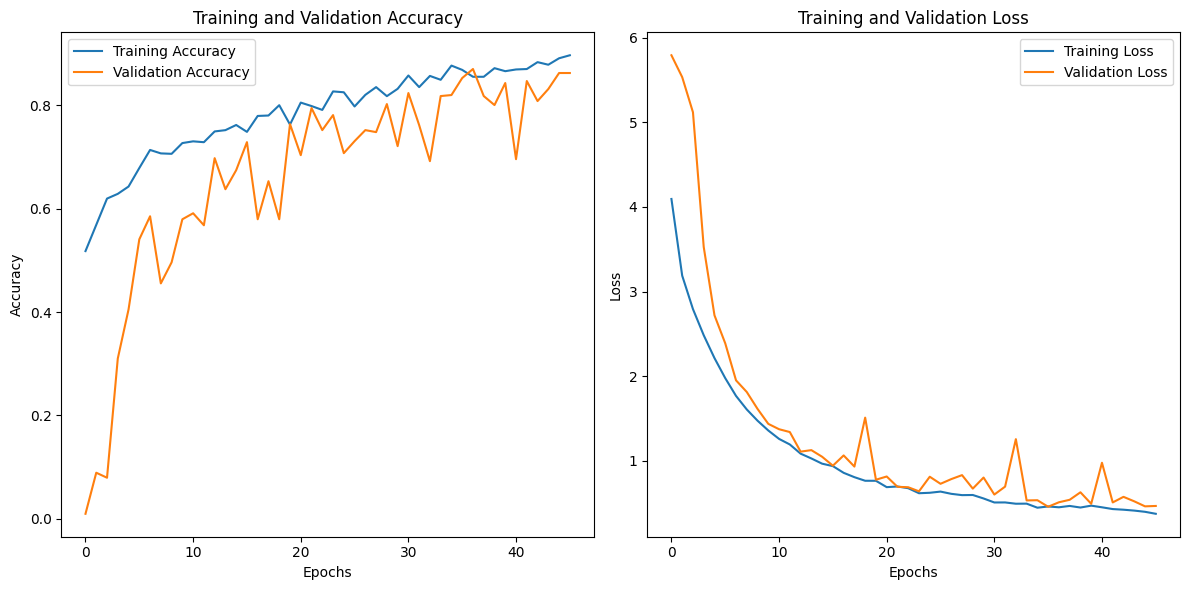

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


<h3>Training and validation loss and accuracy as a function of training epochs</h3>

- Training Accuracy:
    The training accuracy steadily increases over epochs, reaching a plateau around 0.9. This indicates that the model is learning to correctly classify the training data.

- Validation Accuracy:
    The validation accuracy also increases, but it levels off at a lower value than the training accuracy. This suggests that the model is overfitting to the training data and may not generalize well to unseen data.

- Training Loss:
    The training loss decreases significantly over epochs, indicating that the model is learning to make better predictions on the training data.

- Validation Loss:
    The validation loss also decreases initially but starts to increase after a certain number of epochs, confirming the overfitting issue.

At Epoch 46, ReduceLROnPlateau is reducing learning rate to 0.0001250000059371814.38/38" indicates that a learning rate reduction technique was employed to mitigate overfitting. By reducing the learning rate, the model takes smaller steps during the optimization process, which can help it avoid overfitting and find a better solution.


In [65]:
total_params = model.count_params()

bias_params = sum(np.prod(layer.bias.shape) for layer in model.layers if hasattr(layer, 'bias') and layer.bias is not None)

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")
print(f"Non-bias parameters: {total_params - bias_params}")


Total parameters: 186444
Bias parameters: 268
Non-bias parameters: 186176


<h3> Bias and Non-Bias Parameters  </h3>

- **Bias Parameters** 
    
    They make up only a small fraction of the total parameters (268 out of 186,444).


- **Weights Dominate** 
    
    They determine how inputs are transformed by the network. In convolutional layers, each filter has multiple weights, and in Dense layers, weights scale with the number of inputs and outputs.